In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import binary_crossentropy,categorical_crossentropy
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import tensorflow.keras.backend as K
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
fn = 'Enquete_OD_2013_dom108_v3.csv'
df = pd.read_csv(fn,delimiter=';')
df = df.drop(df[df.D_DESRMR ==0].index)
df = df.drop(df[df.D_ORIRMR ==0].index)
cols = ['P_SEXE','P_GRAGE','D_HREDE','D_ORIXCOOR','D_ORIYCOOR','D_DESTXCOOR','D_DESTYCOOR','D_MODE1']
ncols = len(cols)
df = df[cols]
df

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1
0,1,14,930,291500,5045500,291500,5045500,14
1,1,14,1030,291500,5045500,291500,5045500,14
2,1,14,1200,291500,5045500,292500,5045500,14
3,1,14,1300,292500,5045500,291500,5045500,14
4,1,14,1400,291500,5045500,291500,5045500,14
...,...,...,...,...,...,...,...,...
12170,1,5,2700,298500,5042500,292500,5047500,1
12171,2,5,1300,294500,5045500,294500,5046500,14
12172,2,5,1345,294500,5046500,294500,5045500,14
12173,2,5,1600,294500,5045500,299500,5038500,4


In [5]:
def preprocess_data(df):
    # Dictionary to hold the preprocessing objects for each column
    preprocessors = {}
    
    # List to store processed column arrays
    processed_columns = []
    
    for col in df.columns:
        column = df[col]
        
        # Determine if the column is categorical-like based on unique values
        unique_values = column.nunique()
        
        if unique_values < 20:  # Assume categorical-like if < 10 unique values
            # One-hot encode the column
            encoder = OneHotEncoder(sparse_output = False)
            column_encoded = encoder.fit_transform(column.values.reshape(-1, 1))
            processed_columns.append(column_encoded)
            preprocessors[col] = {"encoder": encoder}
        else:
            # Apply min-max scaling to the column
            scaler = MinMaxScaler()
            column_scaled = scaler.fit_transform(column.values.reshape(-1, 1))
            processed_columns.append(column_scaled)
            preprocessors[col] = {"scaler": scaler}
    
    # Concatenate all processed columns horizontally
    processed_data = np.hstack(processed_columns)
    
    return processed_data, preprocessors

def decode_fake_data(fake_data_encoded, preprocessors, original_columns):
    decoded_columns = []
    index = 0

    for col in original_columns:
        # Get the number of unique values in the original column
        if col in preprocessors:
            if "encoder" in preprocessors[col]:
                # This column was one-hot encoded, reverse it
                encoder = preprocessors[col]["encoder"]
                num_classes = encoder.categories_[0].size
                # Take the one-hot encoded slice for this column
                column_encoded = fake_data_encoded[:, index:index + num_classes]
                column_decoded = np.argmax(column_encoded, axis=1)  # Get original class index
                decoded_columns.append(column_decoded)
                index += num_classes
            elif "scaler" in preprocessors[col]:
                # This column was scaled, reverse the scaling
                scaler = preprocessors[col]["scaler"]
                column_scaled = fake_data_encoded[:, index:index + 1]
                column_decoded = scaler.inverse_transform(column_scaled)  # Reverse the scaling
                decoded_columns.append(column_decoded.astype(int))
                index += 1
    
    # Convert the list of decoded columns into a DataFrame
    decoded_df = pd.DataFrame(np.column_stack(decoded_columns), columns=original_columns)
    # decoded_df.P_SEXE+=1
    # decoded_df.P_GRAGE+=2
    # decoded_df.D_MODE1+=1
    
    
    return decoded_df

processed_data,preprocessors = preprocess_data(df)
processed_data.shape

(12038, 38)

In [6]:
processed_data

array([[1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       [1., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [7]:
decode_fake_data(processed_data,preprocessors,cols)

,P_SEXE,P_GRAGE,D_HREDE,D_ORIXCOOR,D_ORIYCOOR,D_DESTXCOOR,D_DESTYCOOR,D_MODE1
0,0,12,930,291500,5045500,291500,5045500,13
1,0,12,1030,291500,5045500,291500,5045500,13
2,0,12,1200,291500,5045500,292500,5045500,13
3,0,12,1300,292500,5045500,291500,5045500,13
4,0,12,1400,291500,5045500,291500,5045500,13
...,...,...,...,...,...,...,...,...
12033,0,3,2700,298500,5042500,292500,5047500,0
12034,1,3,1300,294500,5045500,294500,5046500,13
12035,1,3,1345,294500,5046500,294500,5045500,13
12036,1,3,1600,294500,5045500,299500,5038500,3


In [19]:
# Step 1: Generate the true dataset
# np.random.seed(42)
# column1 = np.random.randint(0, 2, 5000)  # First column: values 0 or 1
# column2 = np.random.randint(0, 3, 5000)  # Second column: values 0, 1, or 2

# # Combine columns and one-hot encode them
# data = np.column_stack((column1, column2))
# data_encoded = np.concatenate([to_categorical(data[:, 0], 2), 
#                                to_categorical(data[:, 1], 3)], axis=1)

# Step 2: Define the VAE model
original_dim = processed_data.shape[1]
latent_dim = 10  # Dimensionality of the latent space
intermediate_dim = 32

# Encoder
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(inputs, x_decoded_mean)

vae.compile(optimizer='adam', loss='BCE')

# Step 3: Train the VAE model
history = vae.fit(processed_data, processed_data, epochs=100, batch_size=32, verbose=1)

# Step 4: Generate synthetic data
# Sampling random points from the latent space
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

Epoch 1/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4484
Epoch 2/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1932
Epoch 3/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1314
Epoch 4/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1078
Epoch 5/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0978
Epoch 6/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0944
Epoch 7/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0929
Epoch 8/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0917
Epoch 9/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0911
Epoch 10/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0904
Epoch 11/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0897
Epoch 12/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0891
Epoch 13/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0888
Epoch 14/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0884
Epoch 15/100
377/377 ━━━━━━━━━━━━━━━━━━━━ 1

KeyboardInterrupt: 

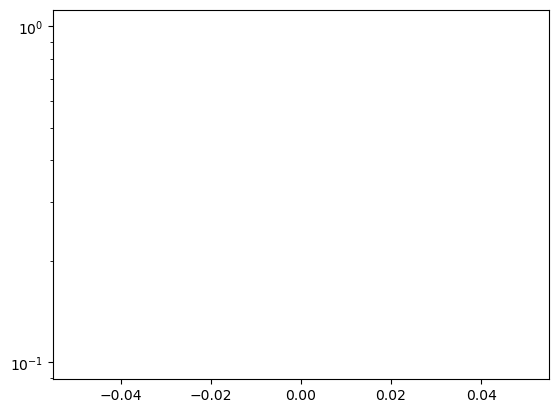

In [20]:
plt.semilogy(history.epoch, history.history["loss"], 'g', label='Training loss')

In [33]:
# Generate 100 synthetic samples
z_sample = np.random.random(size=(1000, latent_dim))
fake_data_encoded = generator.predict(z_sample)
fake_df = decode_fake_data(fake_data_encoded,preprocessors,cols)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


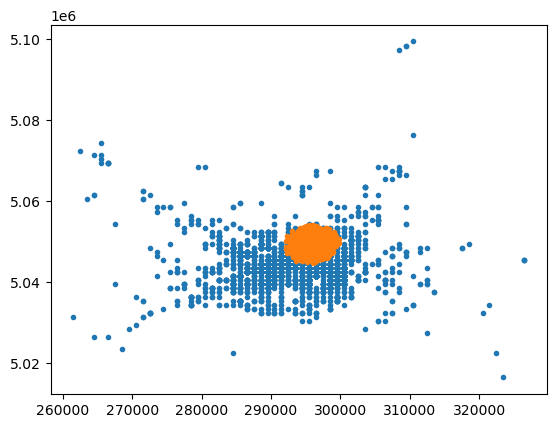

In [28]:
fig, ax = plt.subplots()
ax.plot(df.D_ORIXCOOR,df.D_ORIYCOOR,'.')
ax.plot(fake_df.D_ORIXCOOR,fake_df.D_ORIYCOOR,'.')

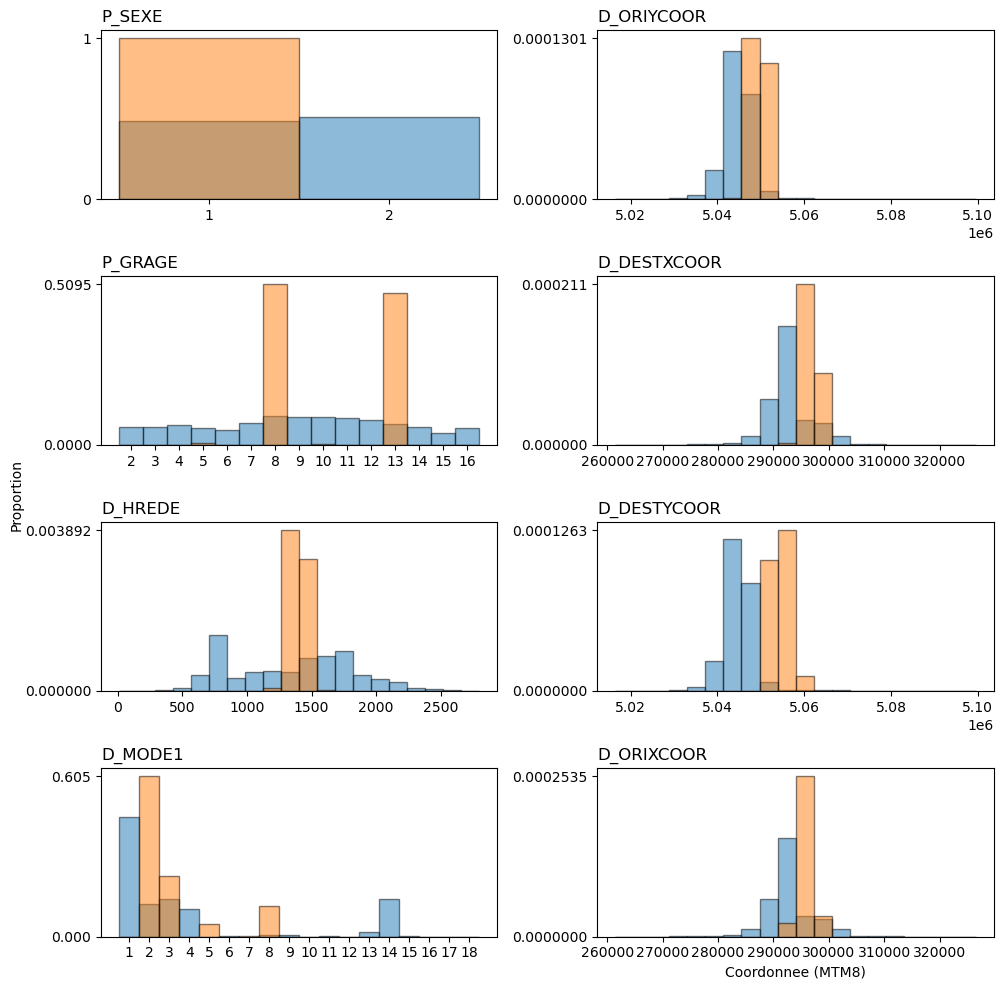

In [35]:
fig, ax = plt.subplots(4,2, figsize = (10,10))

for i in range(len(df.columns)):
    unique_values = df[df.columns[i]].nunique()
    col = 0
    if df.columns[i][-4:]=='COOR':
        col = 1
        
    cat = False
    if unique_values < 20:
        bins = np.arange(np.min(df[df.columns[i]])-0.5,np.max(df[df.columns[i]])+1.5,1)
        cat = True
    else:
        bins = 20
    n,bins,_ = ax[i%4][col].hist(df[df.columns[i]], density = True, alpha = 0.5,bins = bins,edgecolor = 'k')
    n2,bins2,_ = ax[i%4][col].hist(fake_df[fake_df.columns[i]],density = True,alpha = 0.5,bins = bins,edgecolor = 'k')
    ax[i%4][col].set_title(df.columns[i],loc = 'left')
    if cat == True:
        ax[i%4][col].set_xticks(bins[:-1]+0.5,(bins[:-1]+0.5).astype(int))

    ax[i%4][col].set_yticks([0,np.max([n,n2])])
#fig.legend(['Enquete OD','Artificiel'], loc = 'upper center')

fig.text(0.0, 0.5, 'Proportion', va='center', rotation='vertical')
ax[-1,1].set_xlabel('Coordonnee (MTM8)')
fig.tight_layout()
fig.savefig('Figures/GPT_dists_variables.png',dpi = 200)

In [30]:
def compute_distances(df):
    dists = ((df.D_DESTXCOOR-df.D_ORIXCOOR)**2-(df.D_DESTYCOOR-df.D_ORIYCOOR)**2)**0.5
    return dists

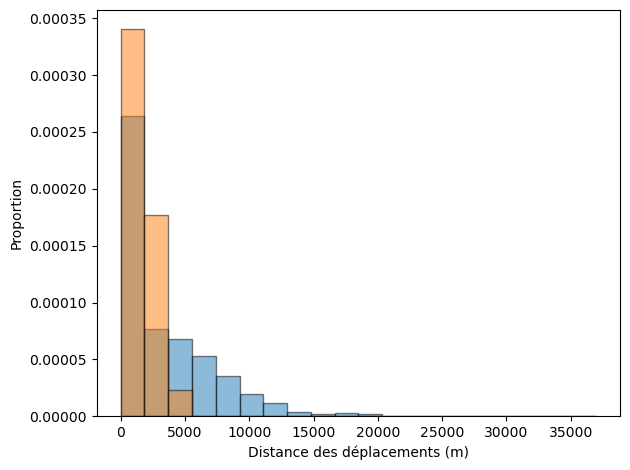

In [34]:
truedists = compute_distances(df)
fakedists = compute_distances(fake_df)

fig, ax = plt.subplots()
n,bins,_ = ax.hist(truedists,bins = 20, alpha = 0.5,edgecolor = 'k',density = True)
ax.hist(fakedists, bins = bins, alpha = 0.5, edgecolor = 'k',density = True)
ax.set_xlabel('Distance des déplacements (m)')
ax.set_ylabel('Proportion')
fig.tight_layout()
fig.savefig('Figures/GPT_distances.png',dpi = 200)